<a href="https://colab.research.google.com/github/Dih08/Cifar_10/blob/main/CIFAR10Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np

from torchvision.datasets import CIFAR10

In [3]:
CATEGORIES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [4]:
#Separando treino e teste
cifar10_train = CIFAR10('caminho', train=True, download=True)
cifar10_test = CIFAR10('caminho', train=False, download=True)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


In [5]:
#Tamanho dos arquivos
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [6]:
def lookat_dataset(dataset, istensor=False):
    figure = plt.figure(figsize=(8, 8))
    rows, cols = 2 ,2
    for i in range(1, 5):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols,  i)
        plt.title(CATEGORIES[label])
        plt.axis("off")
        if istensor:
            plt.imshow(img.squeeze().permute(1, 2, 0))
        else:
            plt.imshow(img)
    plt.show()

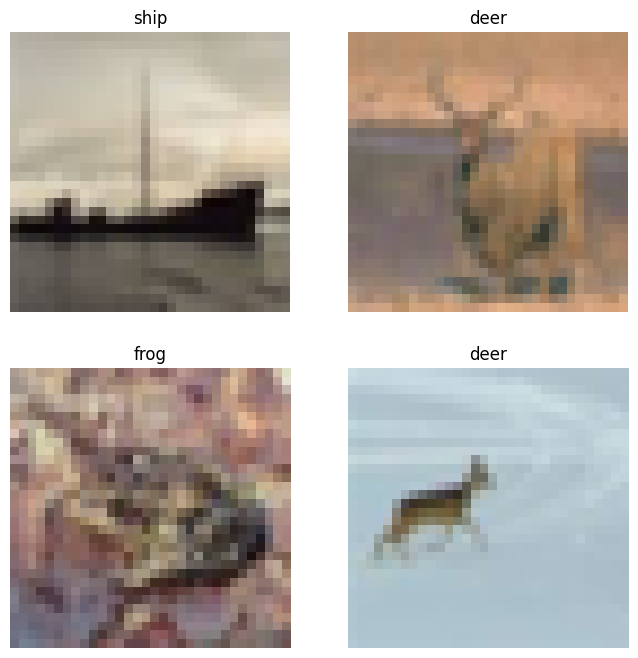

In [7]:
lookat_dataset(cifar10_train)

In [8]:
#Pre-processamneto
import torchvision.transforms as T

preparação = T.Compose(
    [T.ToTensor(),
     T.Normalize(
         (0.4914, 0.4822, 0.4465),
         (0.2470, 0.2435, 0.2616))

    ]
)

t_train = CIFAR10('caminho', train=True ,
                  download=False, transform = preparação)
t_test = CIFAR10('caminho', train=False ,
                 download=False, transform = preparação)

In [9]:
imgs = torch.stack([img_t for img_t, _ in t_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [10]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [11]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

In [12]:
lookat_dataset(t_train, True)

Criando Dataloaders

In [13]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(t_train, batch_size=batch_size, shuffle=True )
test_loader = DataLoader(t_test, batch_size=batch_size, shuffle=True )

MLP = Multilayer Perception

In [14]:
from torch import nn

class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)

        )


    def forward(self, x):
        v = self.flatten(x)
        return self.layers(v)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [16]:
model = MLPClassifier().to(device)

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001)
lossfunc = nn.CrossEntropyLoss()

In [18]:
def train(model, dataloader, lossfunc ,optimizer):
    model.train()
    cumloss = 0.0
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)


      loss = lossfunc(pred, labels)

      optimizer.zero_grad() # zera os gradientes acumulados
      loss.backward() # computa os gradientes
      optimizer.step() # anda , de fato , na direção que reduz o erro local

      cumloss +=loss.item() #loss é um tensor para obter o float
    return cumloss / len(dataloader)

def validate(model, dataloader, lossfunc):
    model.eval()
    cumloss = 0

    with torch.no_grad():
      for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        loss = lossfunc(pred, labels)
        cumloss +=loss.item()

    return cumloss / len(dataloader)



In [19]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13,5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize=16)
  ax.set_xlabel('iteration', fontsize=16)
  ax.set_ylabel('loss', fontsize=16)
  ax.set_title('Losses vs Iterations', fontsize=16)
  plt.show()

In [20]:
epochs = 31
train_losses = []
test_losses = []

for t in range(epochs):
    train_loss = train(model, train_loader, lossfunc, optimizer)
    train_losses.append(train_loss)
    if t % 10 == 0:
      print(f"Epoch: {t}; Train Loss: {train_loss}")
    test_loss = validate(model=model , dataloader=test_loader, lossfunc=lossfunc)
    test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.295305931964494
Epoch: 10; Train Loss: 1.8703658952737403
Epoch: 20; Train Loss: 1.6557033342473648
Epoch: 30; Train Loss: 1.5281805356445215


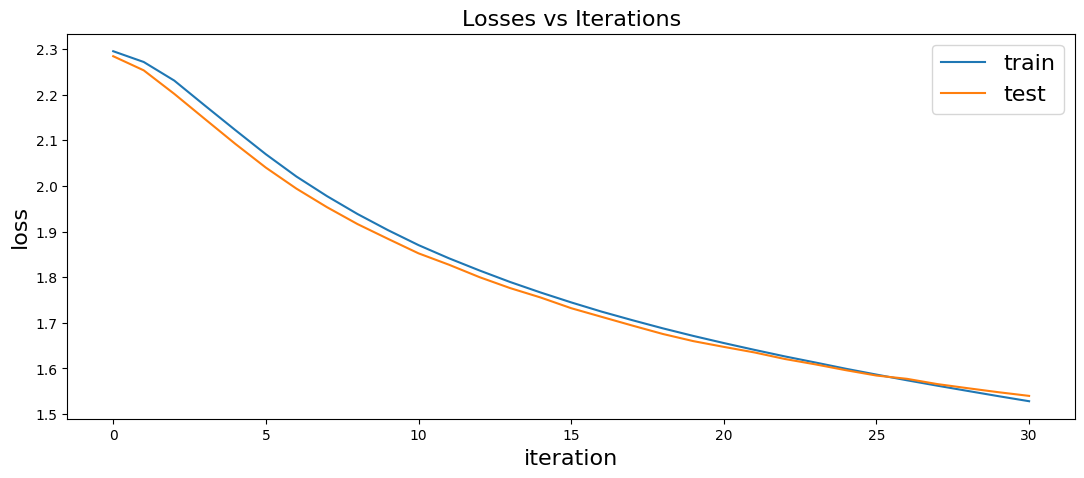

In [21]:
losses = {'train': train_losses, 'test': test_losses}
plot_losses(losses)

In [22]:
def matriz_confusão(model, loader, n_classes):
    confusion_matrix = torch.zeros(n_classes, n_classes)
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix.numpy()

def evaluate_accuracy(model, dataloader, classes, verbose=True):
    confusion_matrix = matriz_confusão(model, dataloader, len(classes))
    if verbose:
        total_correct = 0.0
        total_prediction = 0.0
        for i, classname in enumerate(classes):
            correct_count = confusion_matrix[i][i].item()
            class_pred = torch.sum(torch.tensor(confusion_matrix[i])).item()
            total_correct += correct_count
            total_prediction += class_pred
            accuracy = 100 * float(correct_count) / class_pred
            print("Accuracy for class {:5s} is {:.1f}%".format(classname, accuracy))

        print("Global accuracy {:.1f}%".format(100 * total_correct / total_prediction))
    return confusion_matrix

In [23]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class airplane is 50.4%
Accuracy for class automobile is 55.2%
Accuracy for class bird  is 27.7%
Accuracy for class cat   is 36.6%
Accuracy for class deer  is 28.3%
Accuracy for class dog   is 34.8%
Accuracy for class frog  is 55.8%
Accuracy for class horse is 53.5%
Accuracy for class ship  is 65.8%
Accuracy for class truck is 51.8%
Global accuracy 46.0%


<Axes: >

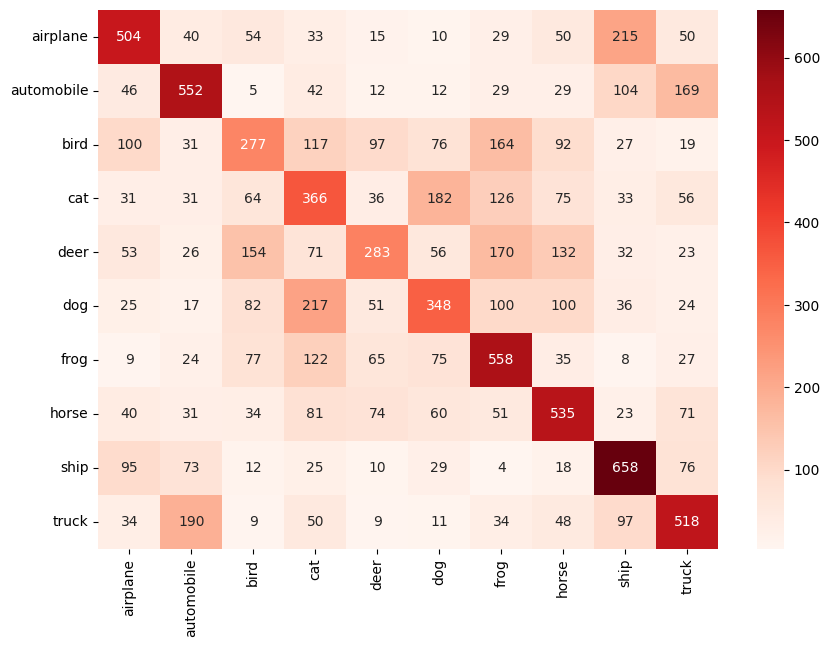

In [25]:
import seaborn as sn

plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Reds', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

In [44]:
class ConvolutionModelo(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )

        self.linearlayer = nn.Sequential(
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = torch.flatten(x, 1)
        return self.linearlayer(x)


In [45]:
convmodel = ConvolutionModelo().to(device)

In [46]:
conv_optimizer = torch.optim.SGD(convmodel.parameters(), lr= 0.001)
conv_lossfunc = nn.CrossEntropyLoss()

In [47]:
epochs = 31
train_losses = []
test_losses = []

for t in range(epochs):
    train_loss = train(convmodel, train_loader, conv_lossfunc, conv_optimizer)
    train_losses.append(train_loss)
    if t % 10 == 0:
      print(f"Epoch: {t}; Train Loss: {train_loss}")
    test_loss = validate(convmodel, test_loader, conv_lossfunc)
    test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.2923759435448807
Epoch: 10; Train Loss: 1.7270549890940146
Epoch: 20; Train Loss: 1.4375289055087683
Epoch: 30; Train Loss: 1.3141983614095947


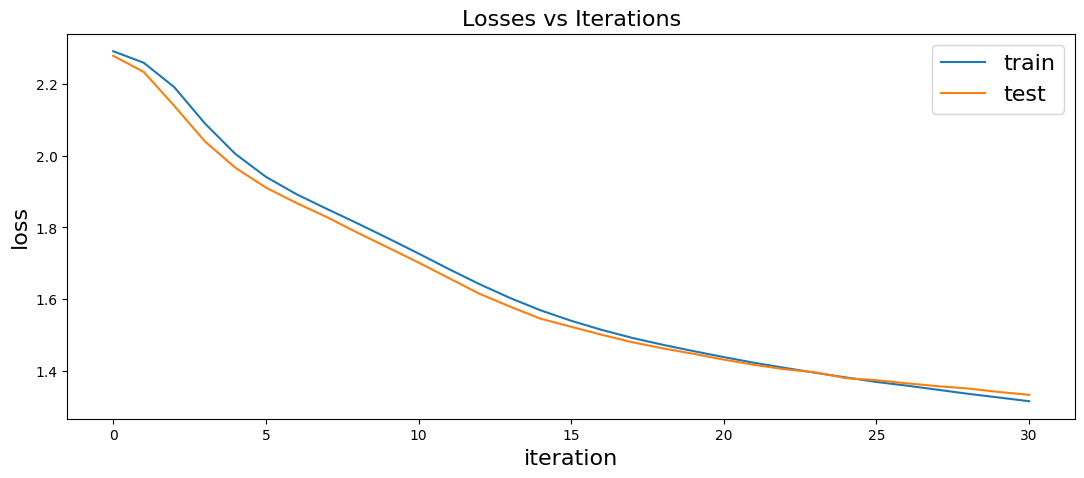

In [51]:
perdas = {'train': train_losses, 'test': test_losses}
plot_losses(perdas)

In [52]:
conv_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is 52.7%
Accuracy for class automobile is 65.6%
Accuracy for class bird  is 38.7%
Accuracy for class cat   is 32.3%
Accuracy for class deer  is 33.9%
Accuracy for class dog   is 54.6%
Accuracy for class frog  is 62.1%
Accuracy for class horse is 61.2%
Accuracy for class ship  is 61.3%
Accuracy for class truck is 62.4%
Global accuracy 52.5%


In [56]:
plt.figure(figsize = (10,7))
sn.heatmap(conv_matrix, annot=True, fmt='g', cmap='Reds', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

<Axes: >

In [48]:
from PIL import Image

img = Image.open('carrinho.jpg')
img

In [57]:
preparação = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize(
         (0.4914, 0.4822, 0.4465),
         (0.2470, 0.2435, 0.2616))

    ]
)

img_tensor = preparação(img)

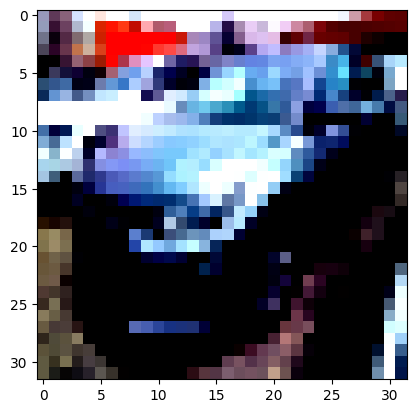

In [58]:
plt.imshow(img_tensor.permute(1, 2, 0))

In [59]:
batch = img_tensor.unsqueeze(0).to(device)

In [60]:
convmodel.eval()

ConvolutionModelo(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayer): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [61]:
output = convmodel(batch)
output

tensor([[ 1.1641,  2.4494, -0.6746, -1.4815, -0.3319, -2.2373, -1.0450, -0.0686,
         -0.2758,  2.2203]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [62]:
probs = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
    prob = probs[0][i].item()
    print(f"{classname}: {prob:.2f}%")
    prob_dict[classname] = [prob]

airplane: 11.60%
automobile: 41.96%
bird: 1.85%
cat: 0.82%
deer: 2.60%
dog: 0.39%
frog: 1.27%
horse: 3.38%
ship: 2.75%
truck: 33.37%


<Axes: >

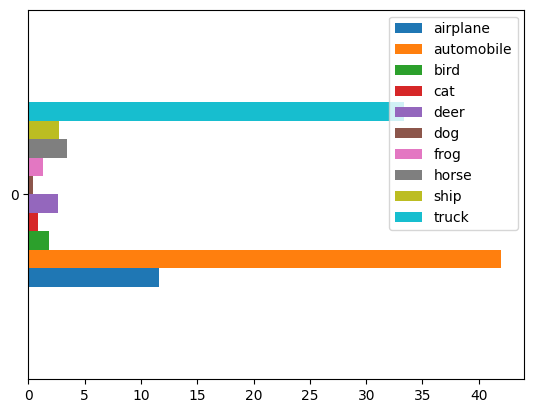

In [68]:
import pandas as pd

df_prob = pd.DataFrame(prob_dict)
df_prob.plot(kind='barh')